## Redo the make_geotiff.ipynb notebook

Below I fix the make_geotiff.ipynb notebook so that Basemap correctly calculates the corner lon/lats of the plotting domain

In [1]:
from e582utils.data_read import download

import numpy as np
import h5py
import sys
import warnings
from matplotlib import pyplot as plt
from IPython.display import Image
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
from e582lib.modis_chans import chan_dict
from e582lib.channels_reproject import subsample,find_corners
from e582lib.channels_reproject import resample_channels,write_h5
from rasterio.transform import from_bounds
import pyproj
import warnings
warnings.filterwarnings("ignore")
import pprint
pp = pprint.PrettyPrinter(indent=4)

%matplotlib inline
myd02file="MYD021KM.A2016224.2100.006.2016225153002.h5"
download(myd02file)

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/MYD021KM.A2016224.2100.006.2016225153002.h5
writing to: MYD021KM.A2016224.2100.006.2016225153002.h5

MYD021KM.A2016224.2100.006.2016225153002.h5 already exists
and is 159039295 bytes
will not overwrite



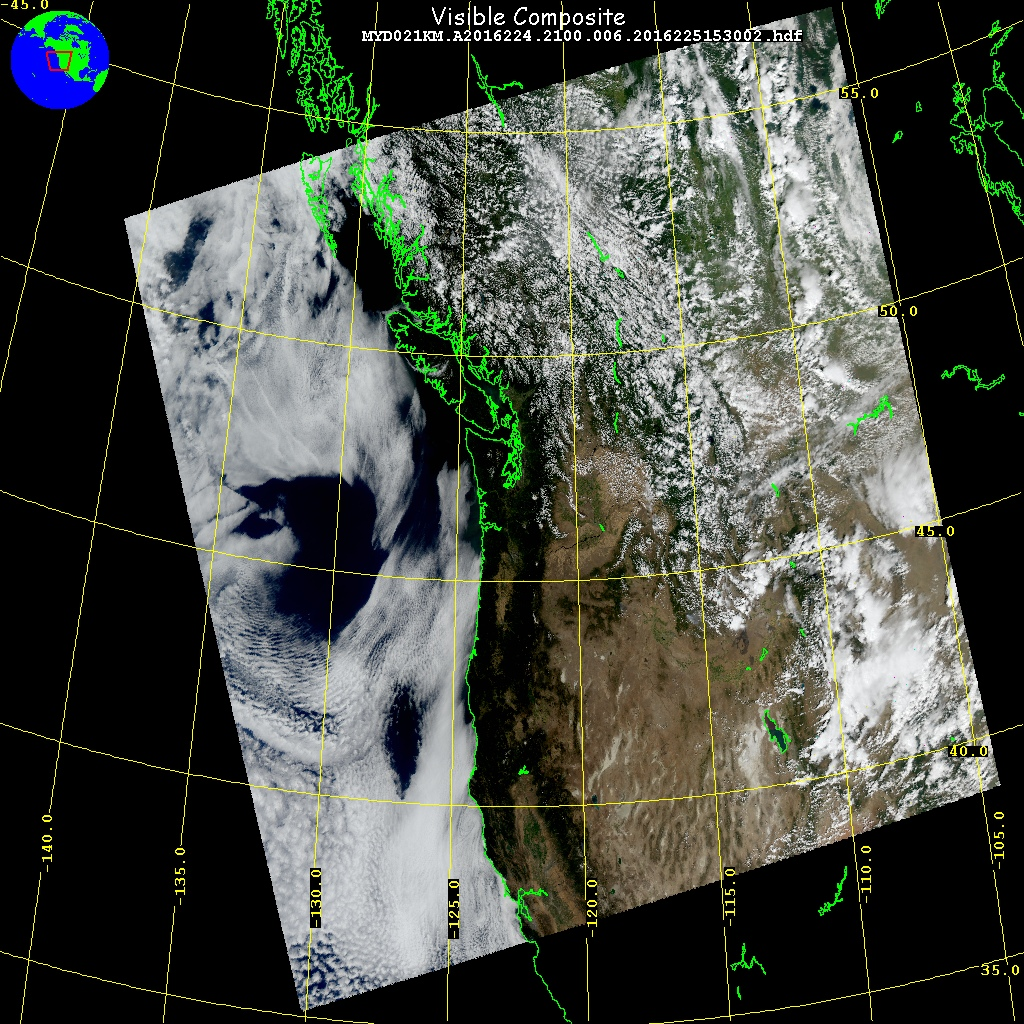

In [2]:
Image('figures/MYBRGB.A2016224.2100.006.2016237025650.jpg')

In [3]:
myd03file="MYD03.A2016224.2100.006.2016225152335.h5"
download(myd03file)

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/MYD03.A2016224.2100.006.2016225152335.h5
writing to: MYD03.A2016224.2100.006.2016225152335.h5

MYD03.A2016224.2100.006.2016225152335.h5 already exists
and is 40795456 bytes
will not overwrite



### Calibrate channel 1,2,3,4 reflectivities



In [4]:
chan_list=['1','2','3','4']
reflectivity_list=[]
for the_chan in chan_list:
    #
    # read channel channels
    #
    index = chan_dict[the_chan]['index']
    field_name = chan_dict[the_chan]['field_name']
    scale_name = chan_dict[the_chan]['scale']
    offset_name = chan_dict[the_chan]['offset']
    with h5py.File(myd02file, 'r') as h5_file:
        chan = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][field_name][
            index, :, :]
        scale = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
            field_name].attrs[scale_name][...]
        offset = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
            field_name].attrs[offset_name][...]
        chan_calibrated = (chan - offset[index]) * scale[index]
        chan_calibrated = chan_calibrated.astype(
            np.float32)  #convert from 64 bit to 32bit to save space
        reflectivity_list.append(chan_calibrated)

with h5py.File(myd03file) as geo_file:
        lon_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Longitude'][...]
        lat_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Latitude'][...]
    #            


### clip a limited 5 degree x 5 degree lat/lon box from the four channels

In [5]:
llcrnr=dict(lat=45,lon= -125)
urcrnr=dict(lat=50,lon= -120)
subsample_list=subsample(*reflectivity_list,lats=lat_data,lons=lon_data,llcrnr=llcrnr,urcrnr=urcrnr)
lats,lons=subsample_list[:2]
numchans=len(subsample_list) -2
rows,cols=lats.shape
chan_array=np.empty([rows,cols,numchans],dtype=np.float32)
for chan in range(numchans):
    chan_array[:,:,chan]=subsample_list[chan+2]


### get the corners of the clipped image for channels_reporoject

In [6]:
corner_dict=find_corners(subsample_list[0],subsample_list[1])
corner_dict

{'lat_0': 47.459999084472656,
 'lat_list': [44.227749, 50.692249],
 'llcrnrlat': 44.227749,
 'llcrnrlon': -127.23767,
 'lon_0': -122.78046417236328,
 'lon_list': [-127.23767, -118.32326],
 'urcrnrlat': 50.692249,
 'urcrnrlon': -118.32326}

### resample the four channels

In [7]:
from e582lib.channels_reproject import resample_channels
chan_list=['1','2','3','4']
result_dict=\
       resample_channels(chan_array,lats,lons,corner_dict)

running resample_chans: here are the mean values of the channels to be resampled
channum and mean 0 0.08828267455101013
channum and mean 1 0.17723044753074646
channum and mean 2 0.11619195342063904
channum and mean 3 0.09927360713481903
pyresample area_def information:

dump area definition:
Area ID: granule
Name: modis swath 5min granule
Projection ID: laea
Projection: {'datum': 'WGS84', 'lat_0': '47.4599990844727', 'lon_0': '-122.7804641723633', 'proj': 'laea', 'units': 'm'}
Number of columns: 516
Number of rows: 552
Area extent: (-356016.46290260204, -349178.12992515496, 314880.87185323943, 368521.51227908855)


x and y pixel dimensions in meters:
1300.1886332477548
1300.1805112395714

completed channels_resample


### calculate the ndvi and write this out for reuse later

In [8]:
#
# add ndvi as a new layer so that channels
# grows to shape= rows x cols x 5
# 
channels=result_dict['channels']
ch1=channels[:,:,0]
ch2=channels[:,:,1]
ndvi=(ch2 - ch1)/(ch2 + ch1)
ndvi=ndvi[:,:,np.newaxis]
channels=np.concatenate((channels,ndvi),axis=2)
chan_list=['modis1','modis2','modis3','modis4','ndvi']
result_dict['channels']=channels
result_dict['chan_list']=chan_list
result_dict['out_file']='vancouver_zoom.h5'
result_dict['comments']='subsampled to vancouver box'
write_h5(**result_dict)

inside write_h5:  (552, 516, 5)
inside write_h5: area_def --
{'area_id': 'granule', 'area_dict': {'lon_0': '-122.7804641723633', 'datum': 'WGS84', 'units': 'm', 'proj': 'laea', 'lat_0': '47.4599990844727'}, 'area_extent': [-356016.46290260204, -349178.12992515496, 314880.87185323943, 368521.51227908855], 'proj_id': 'laea', 'xsize': 516, 'area_name': 'modis swath 5min granule', 'ysize': 552}--



### write out a geotiff file for the ndvi using rasterio

In [9]:
from affine import Affine
import rasterio
geotiff_args = result_dict['geotiff_args']
transform = geotiff_args['affine_transform']
crs = geotiff_args['proj4_string']
fill_value=result_dict['fill_value']
tif_filename='vancouver_ndvi.tif'
ndvi = channels[:,:,4]
data_type = ndvi.dtype
height, width = ndvi.shape
num_chans=1
if fill_value is None:
    fill_value = np.array([np.nan],dtype=data_type)[0]
with rasterio.open(tif_filename,'w',driver='GTiff',
                   height=height,width=width,
                   count=num_chans,dtype=data_type,
                   crs=crs,transform=transform,nodata= fill_value) as dst:
        dst.write(ndvi,1)
print(crs)
print(transform)

+lon_0=-122.7804641723633 +datum=WGS84 +units=m +proj=laea +lat_0=47.4599990844727
| 1300.19, 0.00,-356016.46|
| 0.00,-1300.18, 368521.51|
| 0.00, 0.00, 1.00|


### look at the resampled ndvi

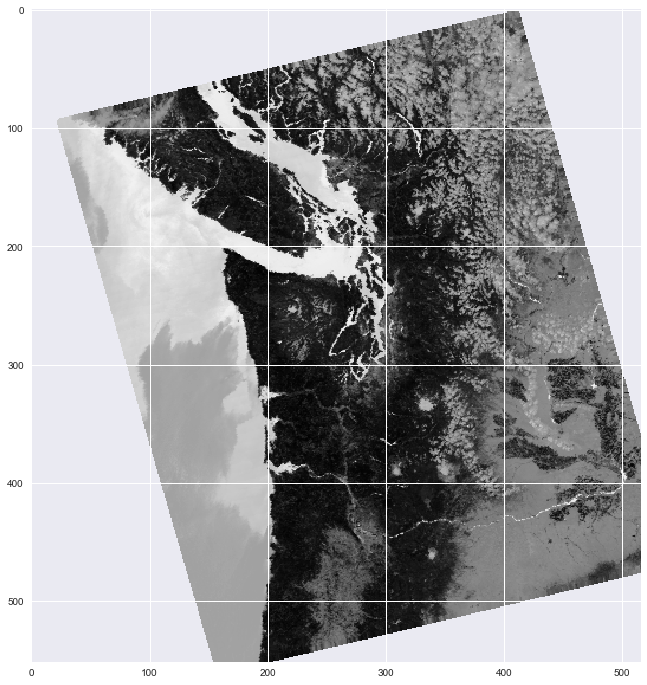

In [10]:
fig,ax=plt.subplots(1,1,figsize=(12,12))
ax.imshow(ndvi)

### make a pallette

In [11]:
cmap=sns.diverging_palette(261, 153,sep=6, s=85, l=66,as_cmap=True)
vmin= -0.9
vmax=  0.9
cmap.set_over('c')
cmap.set_under('k',alpha=0.8)
cmap.set_bad('k',alpha=0.1)
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)

### zoom in on a 200 row x 100 column subscene

#### First, find the lon,lat of the ll and ur corners of the subscene so we can plot with Basemap

In [12]:
ll_col=100
ll_row=200
ur_col=300
ur_row=100
transform = geotiff_args['affine_transform']
crs = geotiff_args['proj4_string']
projection= pyproj.Proj(crs)

ll_x,ll_y = transform*(ll_col,ll_row)
ur_x,ur_y = transform*(ur_col,ur_row)
#lon_0,lat_0 = projection(0,0,inverse=True)
ll_lon,ll_lat = projection(ll_x,ll_y,inverse=True)
ur_lon,ur_lat = projection(ur_x,ur_y,inverse=True)
ll_dict=dict(llcrnrlat=ll_lat,llcrnrlon=ll_lon,urcrnrlat=ur_lat,
              urcrnrlon=ur_lon)

### find the basemap x,y values for each row and column of the subscene

Remember that basemap adds an x_0 and y_0 to the standard transformation, so
we need two steps:

1) first create a basemap instance to get the x_0 and y_0 for the projection
2) then loop through rows 100:200 and columns 100:300, 
   find the x,y and add x_0,y_0

In [22]:
print('ll_dict: \n{}'.format(pp.pformat(ll_dict)))
basemap_args=result_dict['basemap_args']
print('basemap_args: \n{}\n'.format(pp.pformat(basemap_args)))
basemap_args.update(ll_dict)
bmap=Basemap(**basemap_args)
print('bmap projparams: \n{}\n'.format(pp.pformat(bmap.projparams)))
height,width=ndvi.shape
rownums=np.arange(ur_row,ll_row)
colnums=np.arange(ll_col,ur_col)
xline=[]
yline=[]
for the_col in colnums:
    x,y = transform*(the_col,0)
    xline.append(x)
for the_row in rownums:
    x,y= transform*(0,the_row)
    yline.append(y)
xline,yline=np.array(xline),np.array(yline)
xvals, yvals = np.meshgrid(xline,yline)
xvals = xvals + bmap.projparams['x_0']
yvals=yvals + bmap.projparams['y_0']

ll_dict: 
{   'llcrnrlat': 48.39577183306852,
    'llcrnrlon': -125.83310683760826,
    'urcrnrlat': 49.60403989664888,
    'urcrnrlon': -122.30963330457885}
basemap_args: 
{   'ax': <matplotlib.axes._subplots.AxesSubplot object at 0x1239c5a90>,
    'ellps': 'WGS84',
    'lat_0': 47.459999084472656,
    'llcrnrlat': 48.39577183306852,
    'llcrnrlon': -125.83310683760826,
    'lon_0': -122.78046417236328,
    'projection': 'laea',
    'resolution': 'h',
    'urcrnrlat': 49.60403989664888,
    'urcrnrlon': -122.30963330457885}

bmap projparams: 
{   'a': 6378137.0,
    'b': 6356752.314245179,
    'lat_0': 47.459999084472656,
    'lon_0': -122.78046417236328,
    'proj': 'laea',
    'units': 'm',
    'x_0': 225997.5995934412,
    'y_0': -108485.40963765563}



### Use these x,y values to plot the ndvi slice

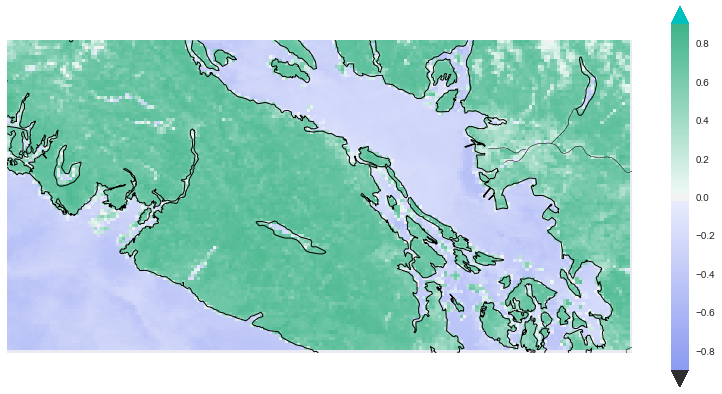

In [25]:
ndvi_zoom=ndvi[ur_row:ll_row,ll_col:ur_col]
plt.close('all')
fig, ax = plt.subplots(1,1,figsize=(14,14))
basemap_args['ax'] = ax
basemap_args['resolution']='h'
bmap = Basemap(**basemap_args)
height,width=ndvi.shape
col=bmap.pcolormesh(xvals,yvals,ndvi_zoom,cmap=cmap,norm=the_norm)
#col=bmap.imshow(ndvi_zoom,cmap=cmap,norm=the_norm,origin='upper')
colorbar=bmap.ax.figure.colorbar(col, shrink=0.5, pad=0.05,extend='both')
bmap.drawcoastlines();
bmap.drawrivers();

### Extra credit

Write this slice out to a geotiff file so it displays correctly in qgis.  To do this you will need to change the affine transform so the x,y coordinates of col0,row0 are set to the current x,y coordinates of col100,row100 (i.e. qgis has no way of knowing that this image is a slice of a larger image.  It needs to be able to get the correct x,y starting at the upper left corner of this slice)

In [26]:
bmap.proj4string

'+y_0=-108485.40963765563 +x_0=225997.5995934412 +proj=laea +lat_0=47.459999084472656 +lon_0=-122.78046417236328 +b=6356752.314245179 +units=m +a=6378137.0 '